# Gaussian Process Wavefront

In [1]:
#Modules

#os
import os

#jax
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap

from gp import gp
from gp.kernels import gaussian_kernel

#matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.patches as patches

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
plt.rcParams.update({'font.size': 20})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

figure_path = 'Figures/gp_wavefront'

In [3]:
#Hyper-Parameters
N_training = 10
N_test = 100
N_sim = 10
N_plot = 10

optimize=True

max_iter = 1000
seed = 2712

x0 = jnp.zeros(2)
theta = jnp.pi/4
t_training= jnp.linspace(0,1,N_training)
t_test = jnp.linspace(0,1,N_test)

k_fun = lambda x,y, beta=1.0, omega=1.0: gaussian_kernel(x,y,beta=beta, omega=omega)
mu_fun = lambda x: jnp.zeros(len(x))

key = jrandom.PRNGKey(seed)
key, subkey = jrandom.split(key)
eps = jrandom.normal(subkey, shape=(N_sim,3))

In [4]:
def trapez_rule(f, t):
    
    dt = jnp.diff(t)
    #fval = vmap(f)(t)
    fval = f
    
    return jnp.concatenate((jnp.zeros(1), jnp.cumsum(0.5*dt*(fval[1:]+fval[:-1]))))

In [5]:
v_fun = lambda x: jnp.ones_like(x)*2.0
GPW1 = gp.GP(mu_fun = mu_fun, k_fun=k_fun, optimize=optimize, max_iter=max_iter)
GPW2 = gp.GP(mu_fun = mu_fun, k_fun=k_fun, optimize=optimize, max_iter=max_iter)

## Sampling from Prior

In [6]:
key = jrandom.PRNGKey(seed)
key, subkey = jrandom.split(key)
eps = jrandom.normal(subkey, shape=(N_sim, N_training,3))

alpha = 1.0
v_prior = v_fun(t_training)
w1_prior = jnp.cos(alpha*t_training)+0.1*eps[:,:,0]
w2_prior = jnp.sin(alpha*t_training)+0.1*eps[:,:,1]

#w1_prior = GPW1.sim_prior(t_training, N_sim=N_sim)
#w2_prior = GPW2.sim_prior(t_training, N_sim=N_sim)

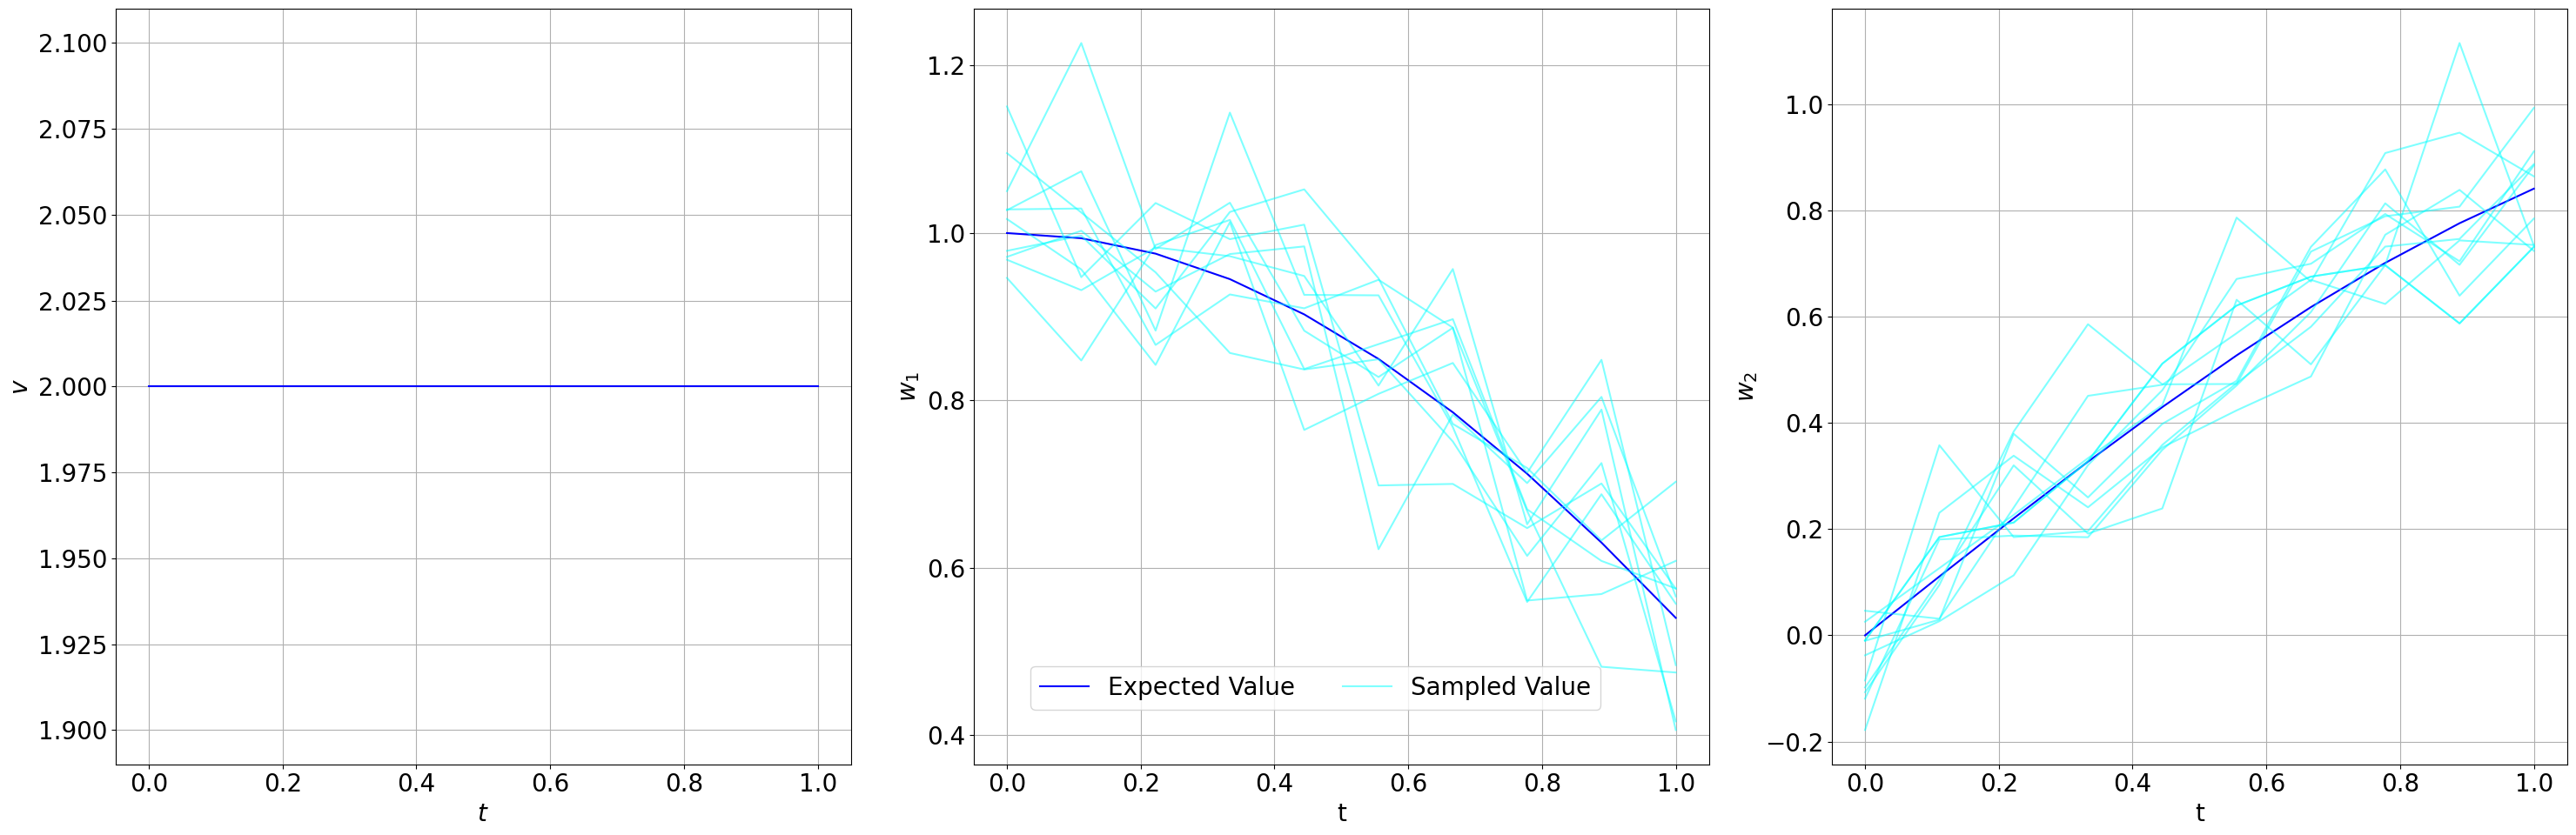

In [7]:
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(131)
ax.plot(t_training, v_prior.T, color='blue')
ax.set_xlabel(f'$t$')
ax.set_ylabel(f'$v$')
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(t_training, jnp.cos(alpha*t_training), color='blue')
ax.plot(t_training, w1_prior[:N_sim].T, color='cyan', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel(f'$w_{1}$')
ax.grid(True)

ax = fig.add_subplot(133)
ax.plot(t_training, jnp.sin(alpha*t_training), color='blue', label='Expected Value')
ax.plot(t_training, w2_prior[:N_sim].T, color='cyan', alpha=0.5)
ax.plot(t_training, w2_prior[0], color='cyan', label='Sampled Value', alpha=0.5)
ax.set_xlabel('t')
ax.set_ylabel(f'$w_{2}$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.15), ncol=5)

fig.tight_layout()
fig.savefig(os.path.join(figure_path, 'gp_prior_vw.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

In [8]:
x1_prior = vmap(lambda w1: x0[0]+jnp.cos(theta)*trapez_rule(v_prior, t_training)+trapez_rule(w1,t_training))(w1_prior)
x2_prior = vmap(lambda w2: x0[1]+jnp.sin(theta)*trapez_rule(v_prior, t_training)+trapez_rule(w2,t_training))(w2_prior)

mu_x1_prior = x0[0]+jnp.cos(theta)*trapez_rule(v_prior, t_training)+trapez_rule(jnp.cos(alpha*t_training),t_training)
mu_x2_prior = x0[1]+jnp.sin(theta)*trapez_rule(v_prior, t_training)+trapez_rule(jnp.sin(alpha*t_training),t_training)

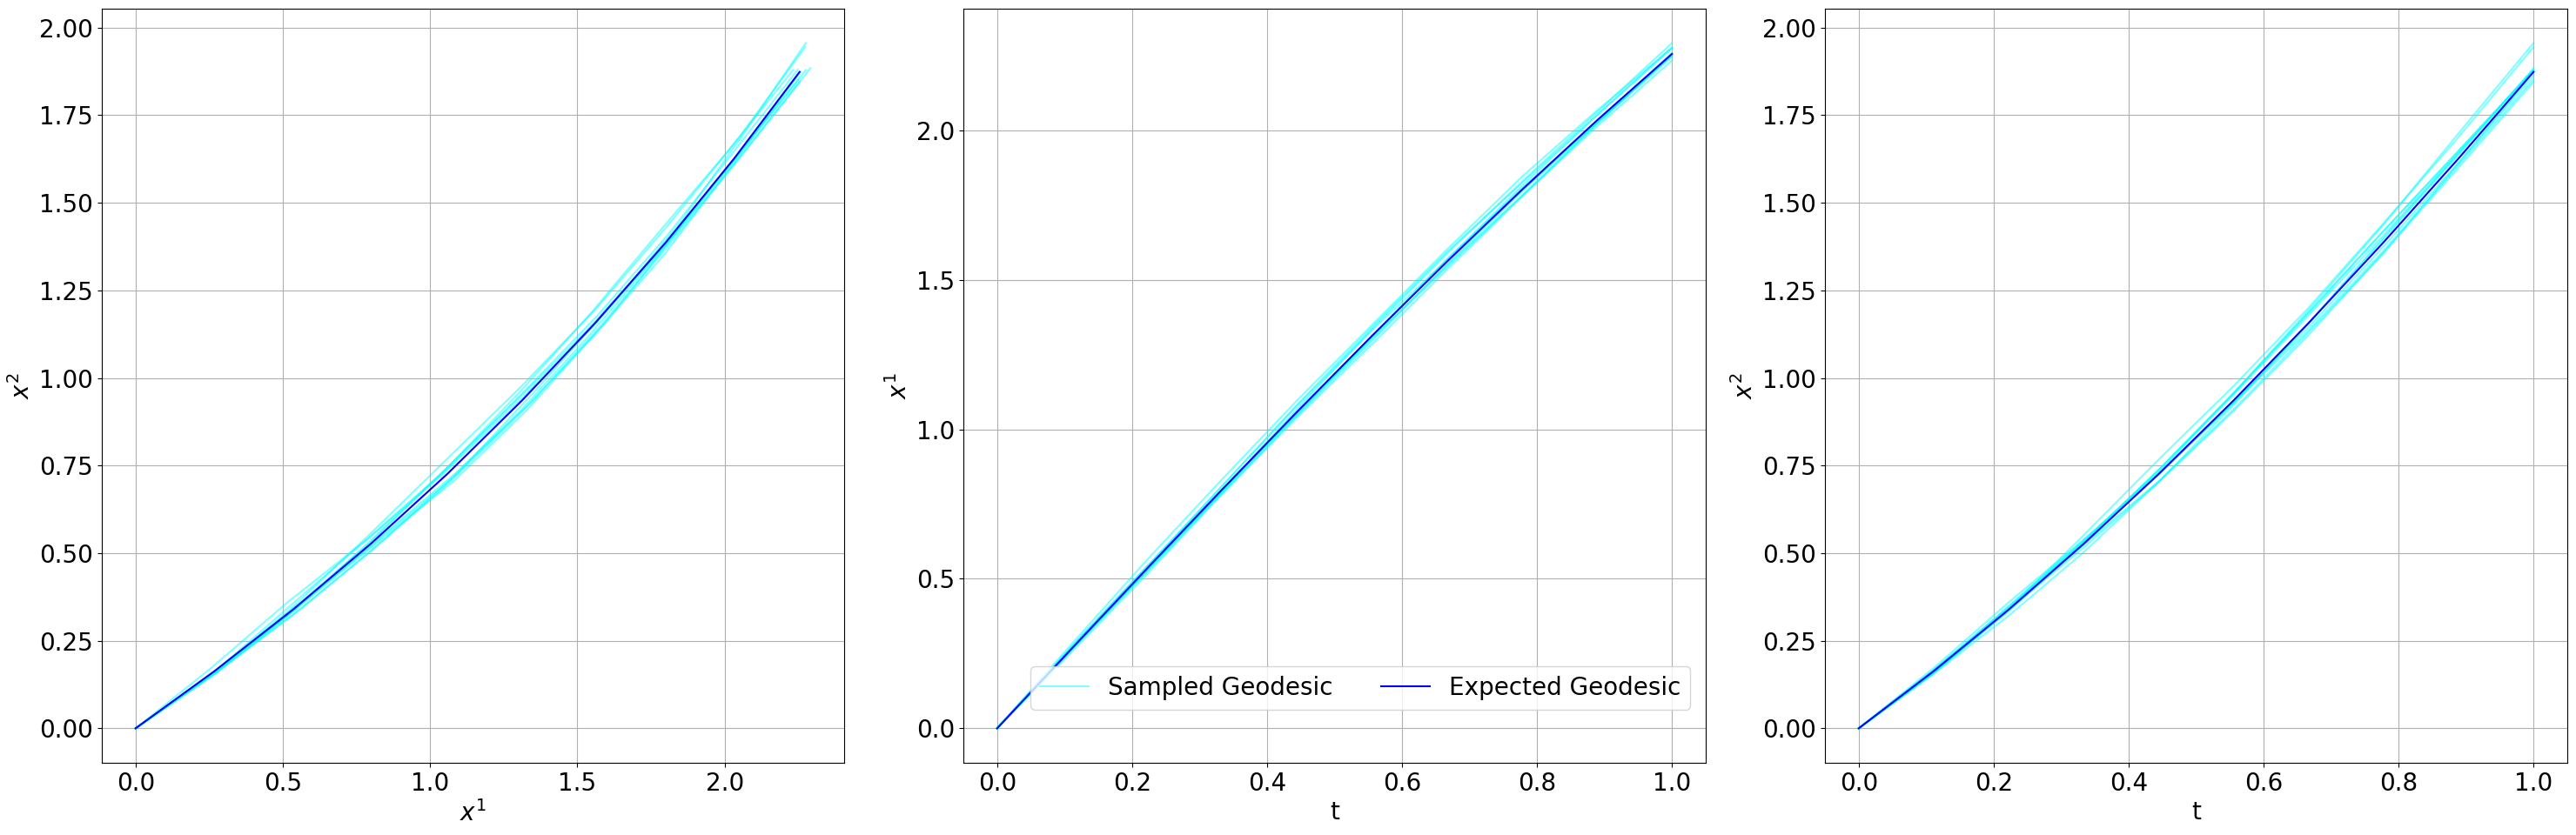

In [9]:
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(131)
ax.plot(x1_prior[:N_plot].T, x2_prior[:N_plot].T, color='cyan', alpha=0.5)
ax.plot(mu_x1_prior.T, mu_x2_prior.T, color='blue')
ax.set_xlabel(f'$x^{1}$')
ax.set_ylabel(f'$x^{2}$')
ax.grid(True)

ax = fig.add_subplot(132)
ax.plot(t_training, x1_prior[:N_plot].T, color='cyan', alpha=0.5)
ax.plot(t_training, mu_x1_prior.T, color='blue')
ax.set_xlabel('t')
ax.set_ylabel(f'$x^{1}$')
ax.grid(True)

ax = fig.add_subplot(133)
ax.plot(t_training, x2_prior[:N_plot].T, color='cyan', alpha=0.5)
ax.plot(t_training, x2_prior[0].T, color='cyan', label='Sampled Geodesic', alpha=0.5)
ax.plot(t_training, mu_x2_prior.T, color='blue', label='Expected Geodesic')
ax.set_xlabel('t')
ax.set_ylabel(f'$x^{2}$')
ax.grid(True)

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.40,0.15), ncol=5)

fig.tight_layout()
fig.savefig(os.path.join(figure_path, 'gp_prior_x1x2.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

## Learning the Posterior Distribution of $v, w_{1}, w_{2}$

In [10]:
sigman = 1.0#jnp.sqrt(jnp.mean(jnp.var(w1_prior, axis=0)))

In [11]:
GPW1.fit(jnp.tile(t_training, (1, N_sim)), w1_prior.reshape(-1), theta_init=jnp.array([1.0,1.0]), sigman=sigman)
w1mu_post, w1cov_post = GPW1.posterior_dist(t_test)
w1var_cov = jnp.diag(w1cov_post)

GPW2.fit(jnp.tile(t_training, (1, N_sim)), w2_prior.reshape(-1), theta_init=jnp.array([1.0,1.0]), sigman=sigman)
w2mu_post, w2cov_post = GPW2.posterior_dist(t_test)
w2var_cov = jnp.diag(w2cov_post)

Optimization terminated successfully.
         Current function value: 95.871841
         Iterations: 35
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 96.206140
         Iterations: 33
         Function evaluations: 63


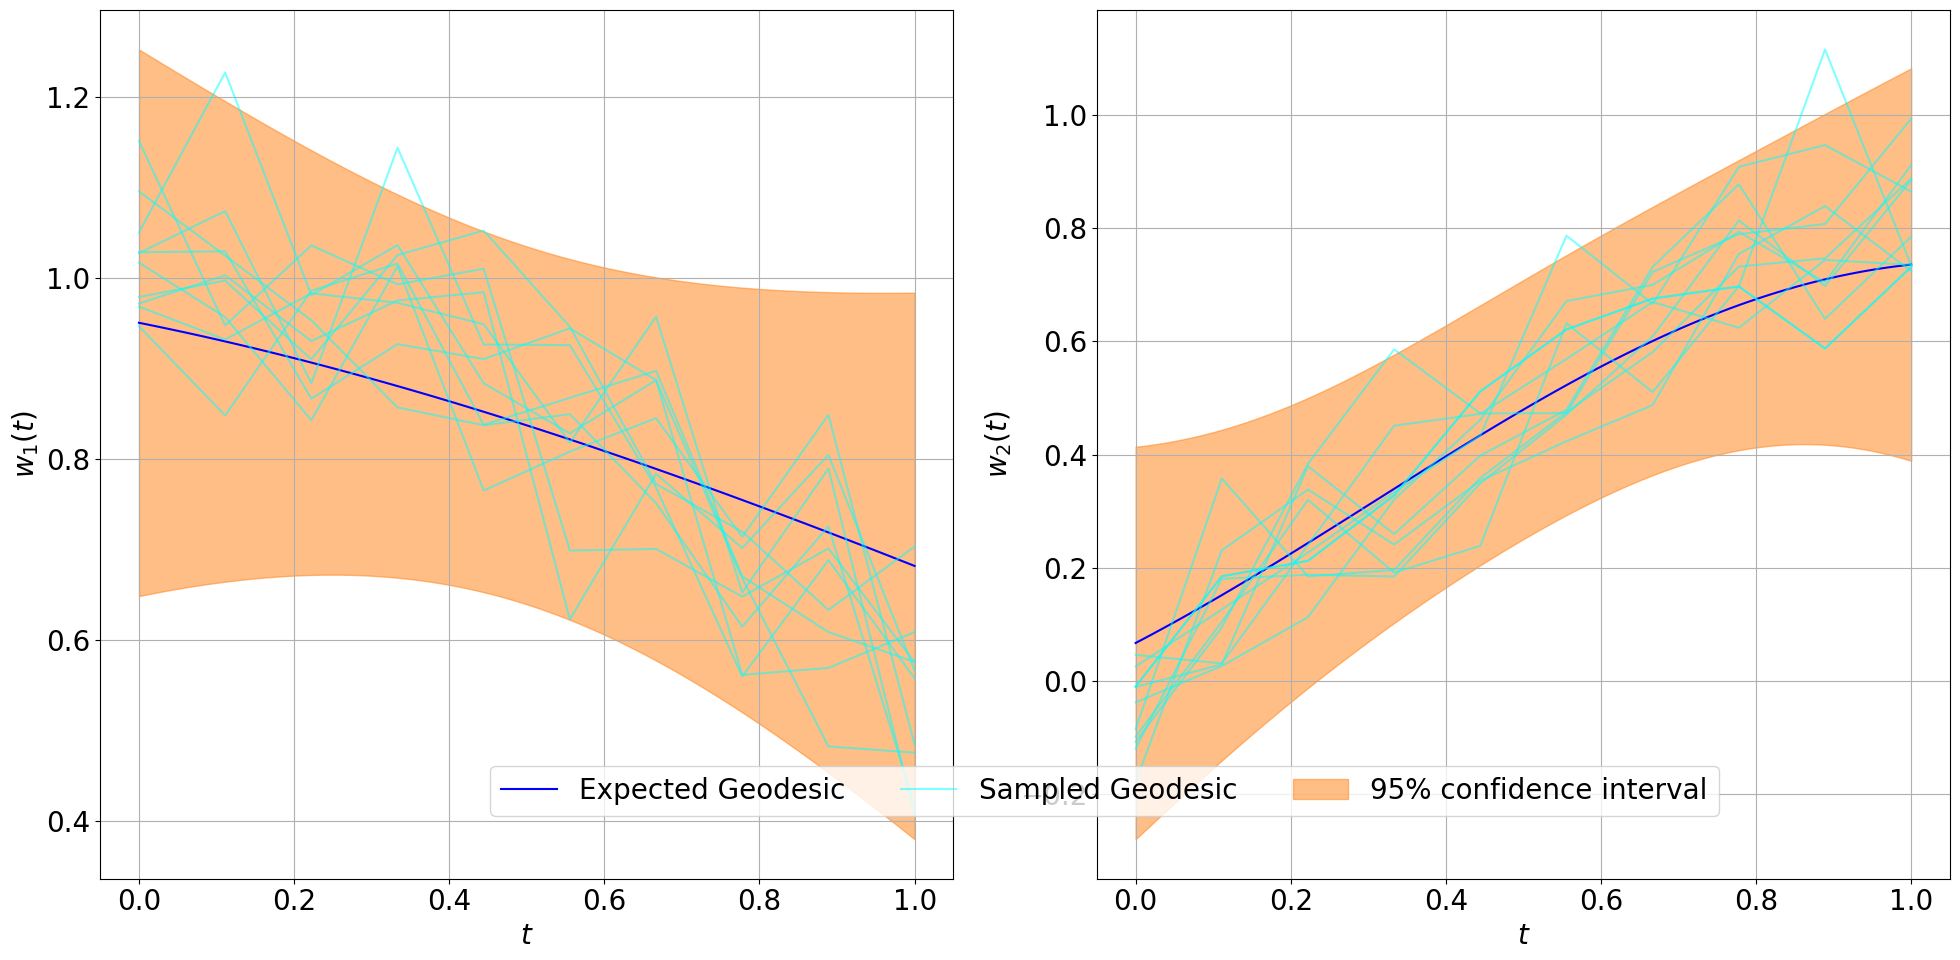

In [12]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121)
ax.plot(t_test, w1mu_post, color='blue')
ax.plot(jnp.tile(t_training,(N_sim,1)).T, w1_prior.T, color='cyan', alpha=0.5)
#ax.plot(jnp.tile(t_test,(N_sim,1)).T, w1_post.T, color='cyan', alpha=1.0)
ax.fill_between(
    t_test.ravel(),
    w1mu_post - 1.96 * jnp.sqrt(w1var_cov),
    w1mu_post + 1.96 * jnp.sqrt(w1var_cov),
    color="tab:orange",
    alpha=0.5,
)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$w_{1}(t)$')

ax = fig.add_subplot(122)
ax.plot(t_test, w2mu_post, label='Expected Geodesic', color='blue')
ax.plot(jnp.tile(t_training,(N_sim,1)).T, w2_prior.T, color='cyan', alpha=0.5)
#ax.plot(jnp.tile(t_test,(N_sim,1)).T, w2_post.T, color='cyan', alpha=1.0)
ax.plot(t_training, w2_prior[0], label="Sampled Geodesic", color='cyan', alpha=0.5)
ax.fill_between(
    t_test.ravel(),
    w2mu_post - 1.96 * jnp.sqrt(w2var_cov),
    w2mu_post + 1.96 * jnp.sqrt(w2var_cov),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$w_{2}(t)$')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.15), ncol=5)

fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'gp_post_vw.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

## Learning the Posterior Distribution for $x^{1},x^{2}$

In [13]:
x1_data = x1_prior-x0[0]-jnp.cos(theta)*v_fun(t_training)
x2_data = x2_prior-x0[1]-jnp.sin(theta)*v_fun(t_training)

In [14]:
mu_funx1 = lambda x: (trapez_rule(mu_fun(jnp.linspace(0,x,100).squeeze()), jnp.linspace(0,x,100).squeeze())[-1] \
-x0[0]-jnp.cos(theta)*v_fun(x)).squeeze()
mu_funx2 = lambda x: (trapez_rule(mu_fun(jnp.linspace(0,x,100).squeeze()), jnp.linspace(0,x,100).squeeze())[-1] \
-x0[1]-jnp.sin(theta)*v_fun(x)).squeeze()

def k_funx(x,y,beta=1.0, omega=1.0):
    
    y_grid = jnp.linspace(0,y,100).squeeze()
    x_grid = jnp.linspace(0,x,100).squeeze()
    
    f_val = vmap(lambda y: trapez_rule(vmap(lambda x: k_fun(x,y,beta,omega))(x_grid), x_grid)[-1])(y_grid)
    
    return trapez_rule(f_val, y_grid)[-1]


In [15]:
GPX1 = gp.GP(mu_fun = mu_funx1, k_fun = lambda x,y: k_funx(x,y,*GPW1.theta), optimize=False)
GPX2 = gp.GP(mu_fun = mu_funx2, k_fun = lambda x,y: k_funx(x,y,*GPW2.theta), optimize=False)

In [16]:
GPX1.fit(jnp.tile(t_training, (1, N_sim)), x1_data.reshape(-1), sigman=0.1)
x1mu_post, x1cov_post = GPX1.posterior_dist(t_test)
x1var_cov = jnp.diag(x1cov_post)

GPX2.fit(jnp.tile(t_training, (1, N_sim)), x2_data.reshape(-1), sigman=0.1)
x2mu_post, x2cov_post = GPX2.posterior_dist(t_test)
x2var_cov = jnp.diag(x2cov_post)

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(40,10))

ax = fig.add_subplot(141)
ax.plot(t_test, w1mu_post, color='blue')
ax.plot(jnp.tile(t_training,(N_sim,1)).T, w1_prior.T, color='cyan', alpha=0.5)
#ax.plot(jnp.tile(t_test,(N_sim,1)).T, w1_post.T, color='cyan', alpha=1.0)
ax.fill_between(
    t_test.ravel(),
    w1mu_post - 1.96 * jnp.sqrt(w1var_cov),
    w1mu_post + 1.96 * jnp.sqrt(w1var_cov),
    color="tab:orange",
    alpha=0.5,
)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$w_{1}(t)$')

ax = fig.add_subplot(142)
ax.plot(t_test, w2mu_post, color='blue')
ax.plot(jnp.tile(t_training,(N_sim,1)).T, w2_prior.T, color='cyan', alpha=0.5)
#ax.plot(jnp.tile(t_test,(N_sim,1)).T, w2_post.T, color='cyan', alpha=1.0)
ax.plot(t_training, w2_prior[0], color='cyan', alpha=0.5)
ax.fill_between(
    t_test.ravel(),
    w2mu_post - 1.96 * jnp.sqrt(w2var_cov),
    w2mu_post + 1.96 * jnp.sqrt(w2var_cov),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$w_{2}(t)$')

ax = fig.add_subplot(143)
ax.plot(t_test, x1mu_post, color='blue')
ax.plot(jnp.tile(t_training,(N_sim,1)).T, x1_data.T, color='cyan', alpha=0.5)
ax.fill_between(
    t_test.ravel(),
    x1mu_post - 1.96 * jnp.sqrt(x1var_cov),
    x1mu_post + 1.96 * jnp.sqrt(x1var_cov),
    color="tab:orange",
    alpha=0.5,
)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$w_{1}(t)$')

ax = fig.add_subplot(144)
ax.plot(t_test, x2mu_post, label='Expected Geodesic', color='blue')
ax.plot(jnp.tile(t_training,(N_sim,1)).T, x2_data.T, color='cyan', alpha=0.5)
ax.fill_between(
    t_test.ravel(),
    x2mu_post - 1.96 * jnp.sqrt(x2var_cov),
    x2mu_post + 1.96 * jnp.sqrt(x2var_cov),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$w_{2}(t)$')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.35,0.15), ncol=5)

fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'gp_simple_post.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

## Reconstructing $w_{1},w_{2}$ using $x_{1},x_{2}$

In [18]:
muw1_jac, covw1_jac = GPX1.jacobian_mom(t_test)
varw1_jac = jnp.diag(covw1_jac)

muw2_jac, covw2_jac = GPX2.jacobian_mom(t_test)
varw2_jac = jnp.diag(covw2_jac)

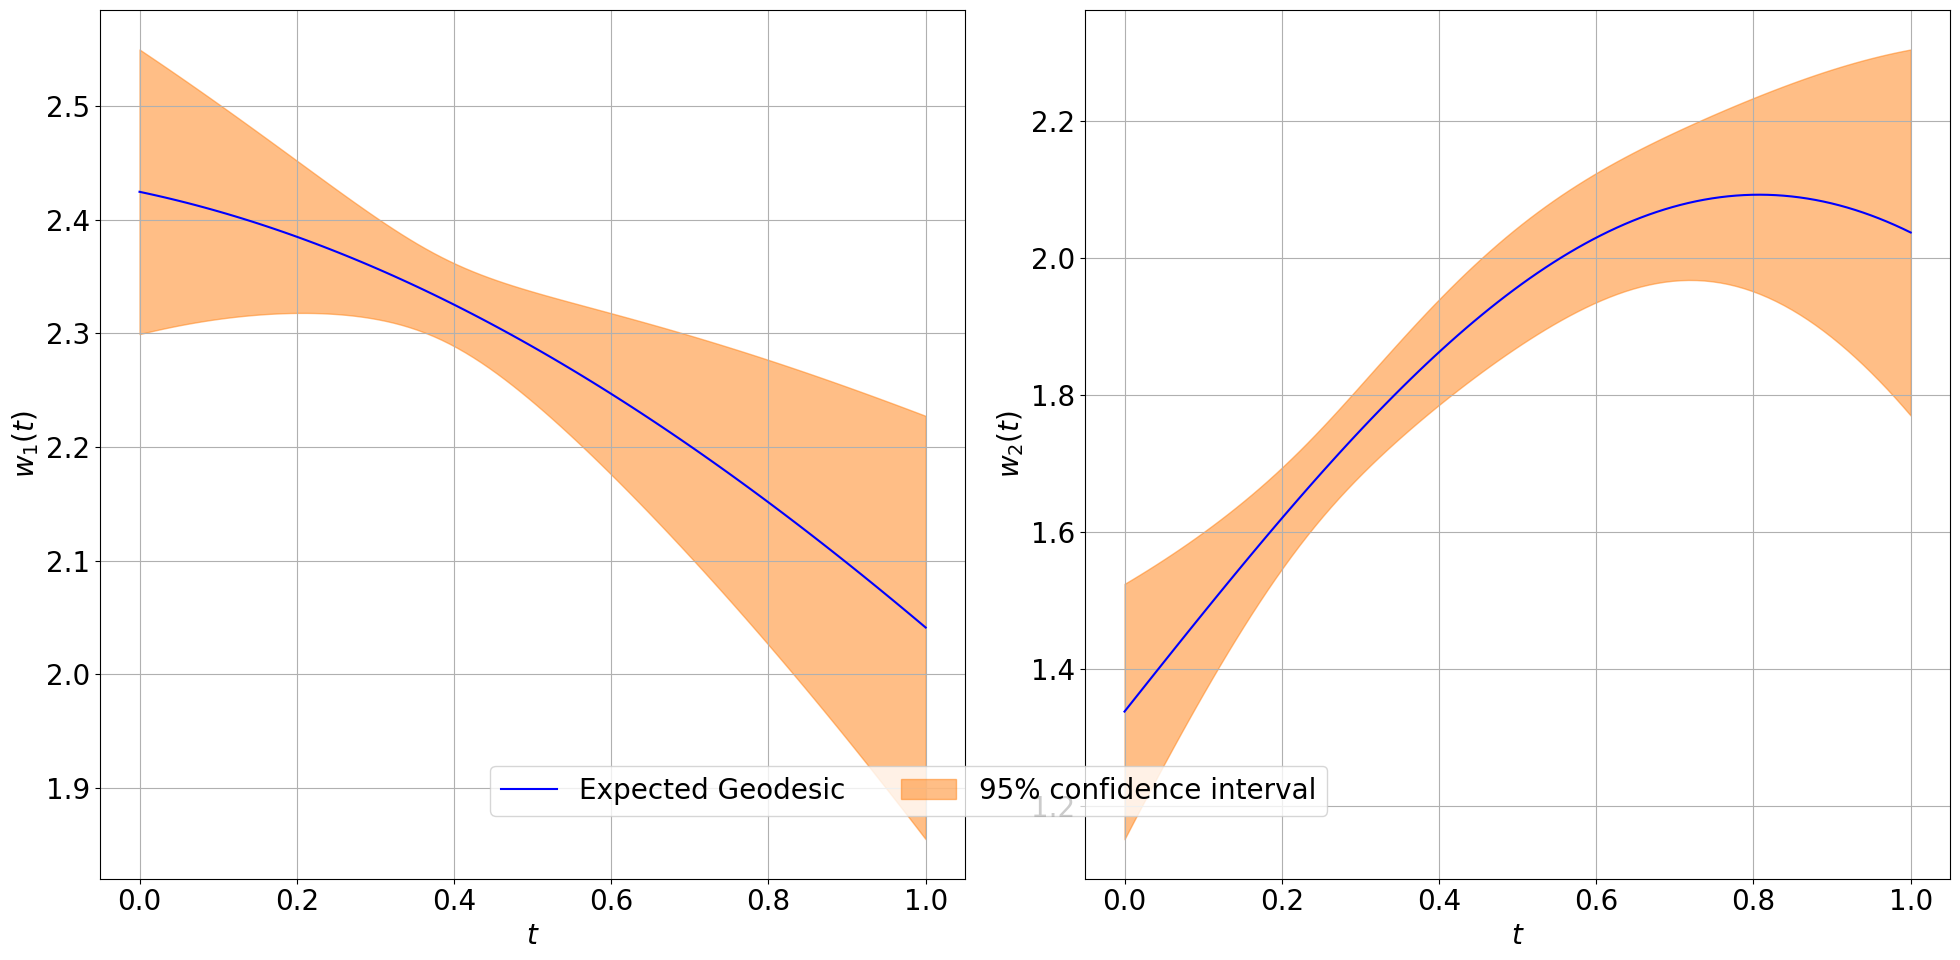

In [20]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121)
ax.plot(t_test, muw1_jac, color='blue')
ax.fill_between(
    t_test.ravel(),
    muw1_jac - 1.96 * jnp.sqrt(varw1_jac),
    muw1_jac + 1.96 * jnp.sqrt(varw1_jac),
    color="tab:orange",
    alpha=0.5,
)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$w_{1}(t)$')

ax = fig.add_subplot(122)
ax.plot(t_test, muw2_jac, label='Expected Geodesic', color='blue')
ax.fill_between(
    t_test.ravel(),
    muw2_jac - 1.96 * jnp.sqrt(varw2_jac),
    muw2_jac + 1.96 * jnp.sqrt(varw2_jac),
    color="tab:orange",
    alpha=0.5,
    label=r"95% confidence interval",
)
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$w_{2}(t)$')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.15), ncol=5)

fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'gp_simple_jac.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')

In [28]:
mux1, covx1 = GPX1.posterior_dist(jnp.linspace(0,1,100))
mux2, covx2 = GPX1.posterior_dist(jnp.linspace(0,1,100))

In [23]:
covx1.shape

(100, 100)

In [36]:
import scipy.stats
i = 50
probx1 = []
probx2 = []
for i in range(len(mux1)):
    probx1.append(scipy.stats.norm(mux1[i], jnp.diag(covx1)[i]).cdf(0.5)-scipy.stats.norm(mux1[i], jnp.diag(covx1)[i]).cdf(0))
    probx2.append(scipy.stats.norm(mux2[i], jnp.diag(covx1)[i]).cdf(0.5)-scipy.stats.norm(mux1[i], jnp.diag(covx1)[i]).cdf(0))
    
probx1 = jnp.stack(probx1)
probx2 = jnp.stack(probx2)
prob = probx1*probx2

/tmp/ipykernel_5584/2864954569.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((0.0, 0.0), 0.5, 0.5, linewidth=1, edgecolor='r', color='red', alpha=0.2)


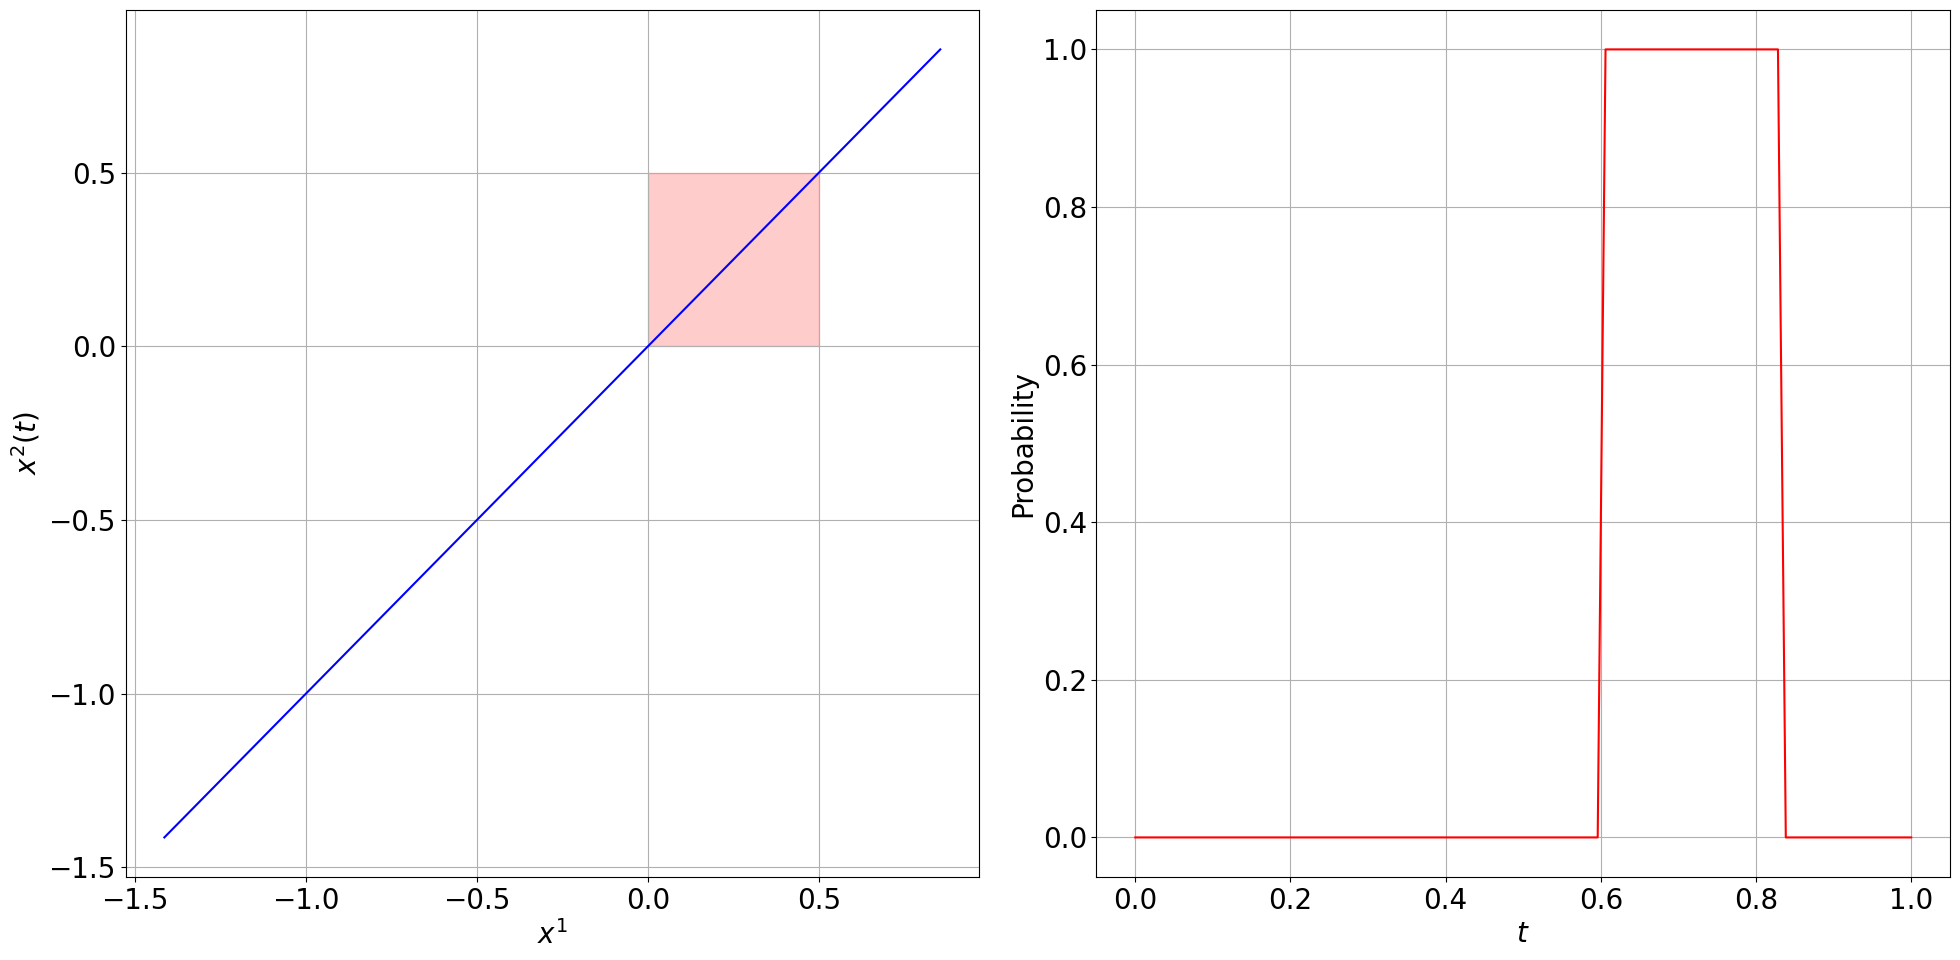

In [47]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(121)
ax.plot(mux1, mux2, color='blue')
ax.grid(True)
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}(t)$')

# Create a Rectangle patch
rect = patches.Rectangle((0.0, 0.0), 0.5, 0.5, linewidth=1, edgecolor='r', color='red', alpha=0.2)

# Add the patch to the Axes
ax.add_patch(rect)

ax = fig.add_subplot(122)
ax.plot(jnp.linspace(0,1,100), prob, color='red')
ax.grid(True)
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'Probability')

fig.tight_layout()

fig.savefig(os.path.join(figure_path, 'gp_simple_prob.pdf'), format='pdf', pad_inches=0.1, bbox_inches='tight')